# SnapChat Filters : Beardify

# Beard Filter

In this chapter, we will learn how to apply beard on a face. The main concepts involved are Warping of triangles, Delaunay Triangulation and Alpha Blending.

| <center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-srcface.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-srcface.jpg" width=400/></a></center> | <center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-bearedFace.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-bearedFace.jpg" width=400/></a></center> |
| -------- | -------- |


## The Core Idea

In the previous section (face swap) we discussed how to extract a person’s face from one image and apply it on another person’s image. We will use a similar approach here.

To apply a beard on a face, we will use beard from source image and apply it on jawline + lips boundary portions of face on destination image. In order to do this, we will need points marked on lips boundary and jawline which define an outline of beard and moustache. There are 2 ways we can get source image of beard:

1. Image of only beard with corresponding dlib points marked manually on the beard.

2. Image of a bearded person

In this case we will use dlib’s facial landmark detector on the face image to get the coordinates of relevant points. But getting an image of a person with beard with alpha mask is very rare.

In this tutorial, we will use first option to apply beard.

Why? Because the image of beard we have, is a png image with transparency mask. We can use this mask for efficiently blending the beard on any given face.

We will use following points (out of 68 landmark points) marked on image to apply beard from source image to destination image.

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-beraedMask.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-beraedMask.jpg" width=400/></a></center>

&nbsp;
We will use these points and affine warp it on the target image using delaunay triangulation. Just like face swap we will also use alpha blending to make blending look smooth. The difference here is that we will use transparency mask of beard and not the mask provided by the convex hull as in the case of faceswap.

You can use this method to overlay any other object like flowerband, spectacles etc, as discussed in the previous chapter.

## Code and Tutorial for Beardify

We have provided code for both the image and video versions. We will explain the video version here. The same explanations go for the image version also. 

Now let’s dive into the code and find out the implementation of the ideas we discussed.

In [1]:
import cv2,sys,dlib,time,math
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

Specify the resize options for working image and image used for Dlib face detector.

In [5]:
FACE_DOWNSAMPLE_RATIO = 1

Since beard points are a subset of the 68 points, we have to select the points from dlib which we have marked on the beard.

<img src="https://www.learnopencv.com/wp-content/uploads/2019/10/ted-beardify-annotation.jpg" width = 1000 />

In [1]:
# Points corresponding to Dlib which have been marked on the beard
selectedIndex = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                 31, 32, 33, 34, 35, 55, 56, 57, 58, 59]

Function to read the contents of the file and convert them into a list called points. This will be used for getting the points corresponding to dlib points for the beard.


In [7]:
# Read points corresponding to beard, stored in text files
def getSavedPoints(beardPointsFile):
  points = []
  lines = np.loadtxt(beardPointsFile, dtype='uint16')
  
  for p in lines:
    points.append((p[0], p[1]))
  
  return points 

Specifying the variables for dlib face landmark detector and input image for swapping the face in the video. 

In [8]:
# Load face detection and pose estimation models.
modelPath = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(modelPath)

Load the transparent png image with the alpha mask. This is done using the `cv2.IMREAD_UNCHANGED` flag. It loads the image with 4 channels. We use the first three channels for the beard and the fourth channel as the mask for the beard.

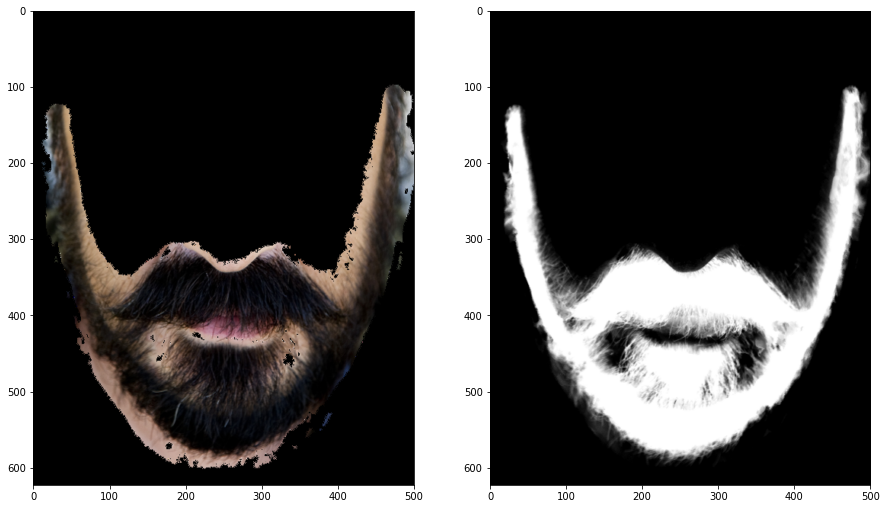

In [12]:
# Load the beard image with alpha mask 
overlayFile = DATA_PATH + "images/beard1.png"
imgWithMask = cv2.imread(overlayFile,cv2.IMREAD_UNCHANGED)

# split the 4 channels
b,g,r,a = cv2.split(imgWithMask)

# Take the first 3 channels and create the bgr image to be warped
beard = cv2.merge((b,g,r))
beard = np.float32(beard)/255

# Take the 4th channel and create the alpha mask used for blending
beardAlphaMask = cv2.merge((a,a,a))
beardAlphaMask = np.float32(beardAlphaMask)
plt.figure(figsize=[15,10])
plt.subplot(121);plt.imshow(beard[...,::-1])
plt.subplot(122);plt.imshow(np.uint8(beardAlphaMask[...,::-1]))


Read the points on the beard which correspond to the dlib points using the function defined above. Find delaunay triangles using these points to perform warping later.


In [13]:
# Read the points marked on the beard
featurePoints1 = getSavedPoints( overlayFile + ".txt")

# Find delanauy traingulation for convex hull points
sizeImg1 = beard.shape    
rect = (0, 0, sizeImg1[1], sizeImg1[0])
dt = fbc.calculateDelaunayTriangles(rect, featurePoints1)

if len(dt) == 0:
    print("No delaunay triangle found")

True

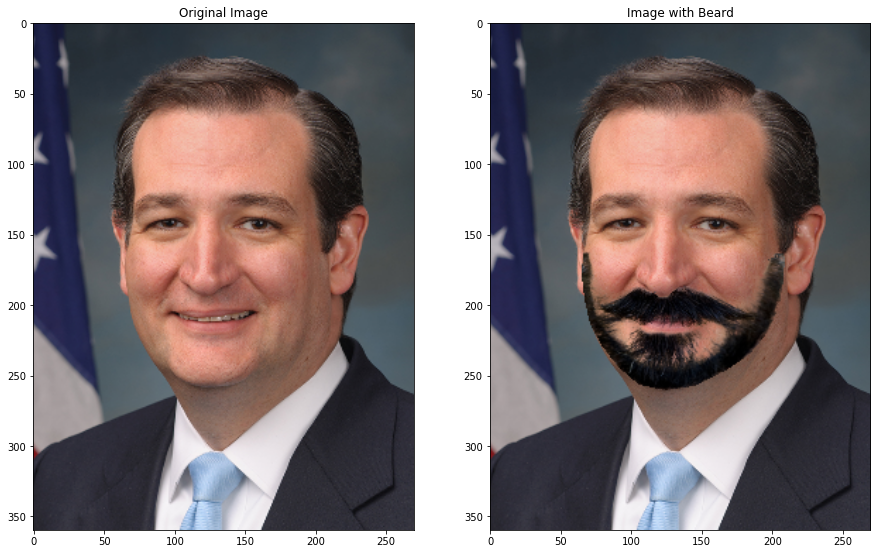

In [18]:
imageFile = DATA_PATH + "images/ted_cruz.jpg";
targetImage = cv2.imread(imageFile)
height, width = targetImage.shape[:2]
IMAGE_RESIZE = np.float32(height)/RESIZE_HEIGHT
targetImage = cv2.resize(targetImage,None,
                 fx=1.0/IMAGE_RESIZE,
                 fy=1.0/IMAGE_RESIZE,
                 interpolation = cv2.INTER_LINEAR)

points2 = fbc.getLandmarks(detector, predictor, cv2.cvtColor(targetImage, cv2.COLOR_BGR2RGB), FACE_DOWNSAMPLE_RATIO)
featurePoints2 = []
for p in selectedIndex:
    pt = points2[p]
    pt = fbc.constrainPoint(pt, width, height)
    featurePoints2.append(pt)

targetImage = np.float32(targetImage)/255

beardWarped = np.zeros(targetImage.shape)
beardAlphaWarped = np.zeros(targetImage.shape)

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
      t1.append(featurePoints1[dt[i][j]])
      t2.append(featurePoints2[dt[i][j]])

    fbc.warpTriangle(beard, beardWarped, t1, t2)
    fbc.warpTriangle(beardAlphaMask, beardAlphaWarped, t1, t2)

beardWarpedMask = beardAlphaWarped/255
temp1 = np.multiply(targetImage, 1.0 - beardWarpedMask)
temp2 = np.multiply(beardWarped, beardWarpedMask)

out = temp1 + temp2;
plt.figure(figsize=[15,10])
plt.subplot(121);plt.imshow(targetImage[...,::-1]);plt.title("Original Image")
plt.subplot(122);plt.imshow(out[...,::-1]);plt.title("Image with Beard")
cv2.imwrite("results/beardify.jpg", np.uint8(255*out))